In [191]:
from pybedtools import BedTool
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import utils
from upsetplot import UpSet, from_contents
from matplotlib_venn import venn2
import numpy as np
import pyBigWig


In [2]:
def intersect_bed_files(bed_file1, bed_file2):
    bed1 = BedTool(bed_file1)
    bed2 = BedTool(bed_file2)

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

In [3]:
def intersect_bed_objects(bed_file1, bed_file2):
    bed1 = bed_file1
    bed2 = bed_file2

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

In [4]:
bed_allpeaks = "/data2st1/junyi/output/atac0416/cCRE/peak.bed"


bed_encode = "/data2st1/junyi/output/atac0416/cCRE/mm10-cCREs.bed"

#https://www.encodeproject.org/annotations/ENCSR127YRL/
bed_rdhs = "/data2st1/junyi/output/atac0416/cCRE/ENCFF414KHO.bed"



In [5]:
merged, non_overlapping = intersect_bed_files(bed_allpeaks, bed_encode)

In [6]:
inter_rdhs, non_overlapping_rdhs = intersect_bed_files(bed_allpeaks, bed_rdhs)

In [7]:
inter_rdhs.saveas("/data2st1/junyi/output/atac0416/cCRE/overlap_rdhs.bed")
non_overlapping.saveas("/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed")

<BedTool(/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed)>

In [8]:
len(merged), len(non_overlapping)

(295713, 1534765)

In [9]:
len(inter_rdhs), len(non_overlapping_rdhs)

(840623, 1836114)

In [10]:
bedall_peaks = BedTool(bed_allpeaks)

In [11]:
df_allpeaks = pd.read_csv(bed_allpeaks, sep="\t", header=None) 
df_allrdhs = pd.read_csv(bed_rdhs, sep="\t", header=None)

In [12]:
n_overlap = len(inter_rdhs)
n_cCRE = len(df_allpeaks)
n_rDHS = len(df_allrdhs)

In [133]:
df_encodeCCRE = pd.read_csv(bed_encode, sep="\t", header=None)

In [134]:
n_overlap_cCRE = len(merged)
n_encodeCCRE = len(df_encodeCCRE)

In [13]:
venn2(subsets=( n_cCRE-n_overlap, n_rDHS-n_overlap, n_overlap), set_labels=('Our cCRE', 'ENCODE rDHS'))
plt.title("Venn Diagram of rDHS and Set B")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_rdhs.svg", dpi=300, bbox_inches='tight')
plt.close()

In [135]:
venn2(subsets=( n_cCRE-n_overlap_cCRE, n_encodeCCRE-n_overlap_cCRE, n_overlap_cCRE), set_labels=('Our cCRE', 'ENCODE cCRE'))
plt.title("Venn Diagram of rDHS and Set B")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_CCRE.svg", dpi=300, bbox_inches='tight')
plt.close()

In [14]:
df_allpeaks.columns = ["chr", "start", "end"]

In [15]:
df_allpeaks['names'] = df_allpeaks['chr'] + ":" + df_allpeaks['start'].astype(str) + "-" + df_allpeaks['end'].astype(str)

In [278]:
annotations = [
    "/data2st1/junyi/generegion_vM23/intron_selected.bed",
    "/data2st1/junyi/generegion_vM23/exon_selected.bed",
    "/data2st1/junyi/generegion_vM23/promoter2k.bed",
    #"/data2st1/junyi/generegion_vM23/repeat.bed",
    "/data2st1/junyi/output/atac0416/cCRE/LINE.bed",
    "/data2st1/junyi/output/atac0416/cCRE/SINE.bed",
    "/data2st1/junyi/output/atac0416/cCRE/LTR.bed",
    "/data2st1/junyi/output/atac0416/cCRE/cpg.bed",
    "/data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed",    
    "/data2st1/junyi/generegion_vM23/UTR.bed",
    "/data2st1/junyi/generegion_vM23/CDS.bed",
    "/data2st1/junyi/generegion_vM23/genebody.bed",
    "/data2st1/junyi/output/atac0416/cCRE/intergenic.bed"
]
dict_annot = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        inte_dar_intron,non_overlapping_in = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/peak.bed", file)
        df_annot = inte_dar_intron.to_dataframe()
        df_annot['names'] = df_annot["chrom"] + ":" + df_annot["start"].astype(str) + "-" + df_annot['end'].astype(str)
        df_annot['gene_name'] = df_annot['itemRgb']
        df_annot['cCRE'] = name
        dict_annot[name] = df_annot
        print(f"Processed {file},{len(dict_annot[name])}")
    except Exception as e:
        print(f"Error processing {file}, {e}")
        continue


# dict_annot = {}
# for file in annotations:
#     name = file.split('/')[-1].replace('.bed', '')
#     try:
#         df_annot = utils.annotate_region(df_allpeaks,region_col='names', bedfile=file)
#         dict_annot[name] = df_annot[df_annot.distance==0]
#         dict_annot['cCRE'] = name
#         print(f"Processed {file},{len(dict_annot[name])}")
#     except:
#         print(f"Error processing {file}")
#         continue


Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,2768449
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,523848
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,106103
Processed /data2st1/junyi/output/atac0416/cCRE/LINE.bed,333429
Processed /data2st1/junyi/output/atac0416/cCRE/SINE.bed,520524
Processed /data2st1/junyi/output/atac0416/cCRE/LTR.bed,352975
Processed /data2st1/junyi/output/atac0416/cCRE/cpg.bed,23833
Processed /data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed,460411


***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



Processed /data2st1/junyi/generegion_vM23/UTR.bed,139236


***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS



Processed /data2st1/junyi/generegion_vM23/CDS.bed,282254


***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody



Processed /data2st1/junyi/generegion_vM23/genebody.bed,881899
Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,892769


In [279]:

gene_regions = {
    'intron': set(dict_annot['intron_selected'].names+"_"+dict_annot['intron_selected'].gene_name),
    'exon': set(dict_annot['exon_selected'].names+"_"+dict_annot['exon_selected'].gene_name),
    'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)

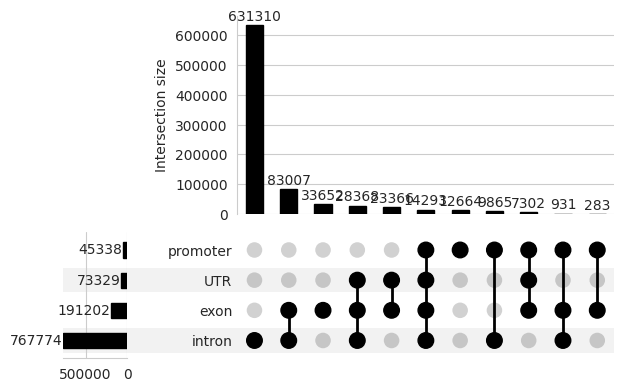

In [280]:

ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()


In [281]:
gene_regions = {
    # 'intron': set(dict_annot['intron_selected'].names+"_"+dict_annot['intron_selected'].gene_name),
    # 'exon': set(dict_annot['exon_selected'].names+"_"+dict_annot['exon_selected'].gene_name),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)

/tmp/ipykernel_1225310/4136633866.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


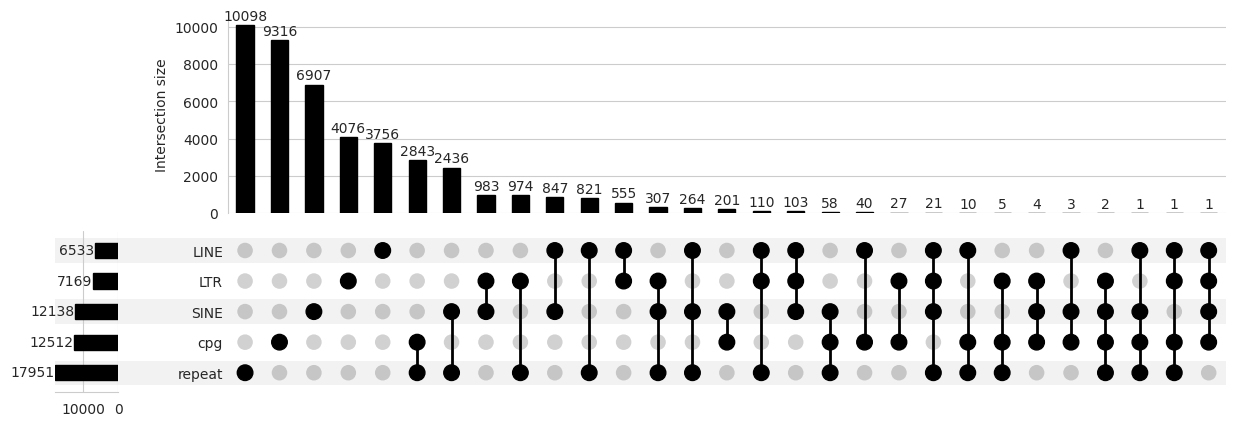

In [293]:
upset = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True)
ax_dict = upset.plot()
# for rect in ax_dict['intersections'].containers:
#     ax_dict['intersections'].bar_label(
#         rect,
#         rotation=45
#     )
# upset = UpSet(gene_regions, subset_size="count", sort_by="cardinality")
# ax_dict2 = upset.plot()

plt.tight_layout()
plt.show()
gene_regions_peaks = gene_regions

,AMY_Sox6_GABA-0-0,PFC_Pvalb_GABA-1-0,AMY_Sox6_GABA-3-1,PFC_L6_CT-0-6,Hippo_Subiculum-1-0,Hippo_Mossy_cell-1-0,Hippo_Htr3a_GABA-1-0,AMY_Dach1_Glut-0-0,Hippo_CA3-d_pyramidal-0-0,PFC_Vip_GABA-0-0,...,Cell_segment-1-0,Hippo_Subiculum-0-0,PFC_Sst_GABA-1-1,AMY_Adamtsl1_Glut-2-1,Immune-0-0,PFC_Pvalb_GABA-0-1,Hippo_CA1-d_pyramidal-1-0,AMY_Adamtsl1_Glut-3-0,PFC_NP-0-1,AMY_Tafa1_Glut-2-0
Peaks,,,,,,,,,,,,,,,,,,,,,
chr1:3003627-3004128,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
chr1:3008717-3009218,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
chr1:3012481-3012982,False,False,False,False,False,False,False,True,True,False,...,False,True,False,True,False,False,True,True,False,False
chr1:3013424-3013925,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
chr1:3014320-3014821,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY:90812678-90813179,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
chrY:90812130-90812631,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
chrY:90811475-90811976,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


intron_selected
exon_selected
promoter2k
LINE
SINE
LTR
cpg
Other_repeats
UTR
CDS
genebody
intergenic


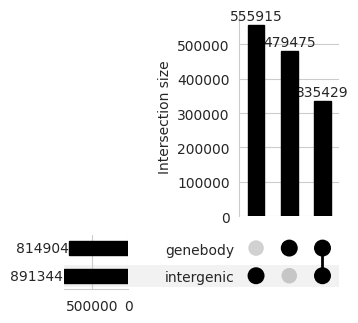

In [283]:
gene_regions = {
    'genebody': set(dict_annot['genebody'].names),
    'intergenic': set(dict_annot['intergenic'].names),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()


In [292]:
from scipy.stats import hypergeom
p_value = hypergeom.sf(m-1, T, M, n)  # 右尾检验


NameError: name 'm' is not defined

In [291]:
gene_regions

id
LINE  SINE  LTR   repeat cpg                                     
True  False False True   False  chr8:13694656-13695157_intergenic
                  False  False    chr1:155973673-155974174_Gm9694
                         False      chr15:79798536-79799037_Nptxr
      True  False False  False      chr14:26491099-26491600_Slmap
      False False False  False    chr4:106787743-106788244_Acot11
...                                                           ...
False False False False  True    chr8:121653251-121653752_Zcchc14
                         True      chr6:88446303-88446804_Gm44264
                         True       chr4:137276418-137276919_Wnt4
                         True      chrX:151802971-151803472_Huwe1
                         True        chr11:79254467-79254968_Wsb1

[44770 rows x 1 columns]

In [69]:
# If the peak macs ends
df_allpeaks = pd.read_csv("/data2st1/junyi/output/atac0416/iterative/peaks.csv",index_col=0)

In [70]:
df_allpeaks.set_index('Peaks', inplace=True)

In [ ]:
df_nonoverlapping = pd.read_csv("/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed", sep="\t", header=None)    

In [72]:
df_nonoverlapping["names"] = df_nonoverlapping[0] + ":" + df_nonoverlapping[1].astype(str) + "-" + df_nonoverlapping[2].astype(str) 

In [75]:
df_overlapping = pd.read_csv("/data2st1/junyi/output/atac0416/cCRE/overlap_rdhs.bed", sep="\t", header=None)
df_overlapping["names"] = df_overlapping[0] + ":" + df_overlapping[1].astype(str) + "-" + df_overlapping[2].astype(str)

In [77]:
#df_overlap = df_allpeaks.loc[list(set(df_nonoverlapping.names.values).difference(set(df_allpeaks.index.values)))]
df_unoverlap = df_allpeaks.loc[list(set(df_nonoverlapping.names.values).intersection(set(df_allpeaks.index.values)))]
df_overlap = df_allpeaks.loc[list(set(df_overlapping.names.values).intersection(set(df_allpeaks.index.values)))]

In [85]:
df_unoverlap_count = df_unoverlap.sum(axis=1).reset_index()

In [86]:
df_overlap_count = df_overlap.sum(axis=1).reset_index()

In [92]:
df_overlap_count["count"] = df_overlap_count[0].clip(0,10)
df_unoverlap_count["count"] = df_unoverlap_count[0].clip(0,10)

In [95]:
df_unoverlap_count.groupby("count").size().reset_index(name='counts')

,count,counts
0,1,407045
1,2,161164
2,3,88830
3,4,59317
4,5,44510
5,6,34776
6,7,28615
7,8,23966
8,9,20633
9,10,262381


In [97]:
df_overlap_count.groupby("count").size().reset_index(name='counts').counts

0    123068
1     69049
2     45250
3     33473
4     26924
5     21640
6     18660
7     16202
8     14391
9    323799
Name: counts, dtype: int64

In [111]:
cluster_counts = df_overlap_count.groupby("count").size().reset_index(name='counts').counts.values.tolist()

In [120]:
df_ovlap_c = df_overlap_count.groupby("count").size().reset_index(name='counts')
df_unoverlap_c = df_unoverlap_count.groupby("count").size().reset_index(name='counts')

In [116]:
df_ovlap_c

,count,counts
0,1,123068
1,2,69049
2,3,45250
3,4,33473
4,5,26924
5,6,21640
6,7,18660
7,8,16202
8,9,14391
9,10,323799


<Axes: ylabel='counts'>

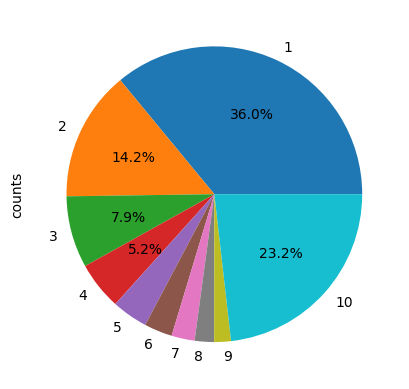

In [130]:
df_unoverlap_c.set_index('count').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)


<Axes: ylabel='counts'>

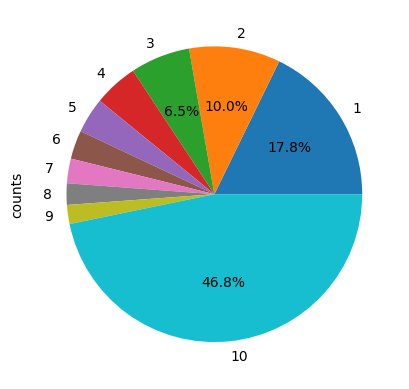

In [132]:
df_ovlap_c.set_index('count').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)


In [140]:
df_deg = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_mememto.csv")

In [413]:
df_wicox = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv")

In [152]:
df_deg.names.str.split(r"[:-]",expand=True).to_csv("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed",index=False,header=False, sep="\t")

In [272]:
# annotations = [
#     "/data2st1/junyi/generegion_vM23/intron_selected.bed",
#     "/data2st1/junyi/generegion_vM23/exon_selected.bed",
#     "/data2st1/junyi/generegion_vM23/promoter2k.bed",
#     #"/data2st1/junyi/generegion_vM23/repeat.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/LINE.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/SINE.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/LTR.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/cpg.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed",    
#     "/data2st1/junyi/generegion_vM23/UTR.bed",
#     "/data2st1/junyi/generegion_vM23/CDS.bed",
#     "/data2st1/junyi/generegion_vM23/genebody.bed",
#     "/data2st1/junyi/output/atac0416/cCRE/intergenic.bed"
# ]

dict_annot_deg = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        inte_dar_intron,non_overlapping_in = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed", file)
        df_annot = inte_dar_intron.to_dataframe()
        df_annot['names'] = df_annot["chrom"] + ":" + df_annot["start"].astype(str) + "-" + df_annot['end'].astype(str)
        df_annot['gene_name'] = df_annot['itemRgb']
        df_annot['cCRE'] = name
        dict_annot_deg[name] = df_annot
        print(f"Processed {file},{len(dict_annot_deg[name])}")
    except Exception as e:
        print(f"Error processing {file}, {e}")
        continue

# dict_annot_deg = {}
# for file in annotations:
#     name = file.split('/')[-1].replace('.bed', '')
#     try:
#         df_annot = utils.annotate_region(df_deg[["names","ctname","condition"]],region_col='names', bedfile=file)
#         dict_annot_deg[name] = df_annot[df_annot.distance==0]
#         dict_annot_deg['cCRE'] = name
#         print(f"Processed {file},{len(dict_annot_deg[name])}")
#     except Exception as e:
#         print(f"Error processing {file}, {e}")
        
#         continue

Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,203276
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,162702
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,82062
Processed /data2st1/junyi/output/atac0416/cCRE/LINE.bed,5463
Processed /data2st1/junyi/output/atac0416/cCRE/SINE.bed,14913
Processed /data2st1/junyi/output/atac0416/cCRE/LTR.bed,6451
Processed /data2st1/junyi/output/atac0416/cCRE/cpg.bed,35159
Processed /data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed,33288


***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



Processed /data2st1/junyi/generegion_vM23/UTR.bed,92889


***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS



Processed /data2st1/junyi/generegion_vM23/CDS.bed,52053


***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody



Processed /data2st1/junyi/generegion_vM23/genebody.bed,85759
Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,59409


In [ ]:
# df_wilcoxon = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv")
# dict_annot_wil = {}
# for file in annotations:
#     name = file.split('/')[-1].replace('.bed', '')
#     try:
#         df_annot = utils.annotate_region(df_wilcoxon[["names","ctname","condition"]],region_col='names', bedfile=file)
#         dict_annot_wil[name] = df_annot[df_annot.distance==0]
#         dict_annot_wil['cCRE'] = name
#         print(f"Processed {file},{len(dict_annot_wil[name])}")
#     except Exception as e:
#         print(f"Error processing {file}, {e}")
        
#         continue

Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,45659
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,28429
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,17822
Processed /data2st1/junyi/output/atac0416/cCRE/LINE.bed,6759
Processed /data2st1/junyi/output/atac0416/cCRE/SINE.bed,13040
Processed /data2st1/junyi/output/atac0416/cCRE/LTR.bed,7424
Processed /data2st1/junyi/output/atac0416/cCRE/cpg.bed,20353
Processed /data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed,20894
Processed /data2st1/junyi/generegion_vM23/UTR.bed,21690
Processed /data2st1/junyi/generegion_vM23/CDS.bed,13120
Processed /data2st1/junyi/generegion_vM23/genebody.bed,56917
Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,51428


In [ ]:
dict_annot_wil = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        inte_dar_intron,non_overlapping_in = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed", file)
        df_annot = inte_dar_intron.to_dataframe()
        df_annot['names'] = df_annot["chrom"] + ":" + df_annot["start"].astype(str) + "-" + df_annot['end'].astype(str)
        df_annot['gene_name'] = df_annot['itemRgb']
        df_annot['cCRE'] = name
        dict_annot_wil[name] = df_annot
        print(f"Processed {file},{len(dict_annot_wil[name])}")
    except Exception as e:
        print(f"Error processing {file}, {e}")
        continue

Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,172723
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,100534
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,48476
Processed /data2st1/junyi/output/atac0416/cCRE/LINE.bed,7629
Processed /data2st1/junyi/output/atac0416/cCRE/SINE.bed,15928
Processed /data2st1/junyi/output/atac0416/cCRE/LTR.bed,8691
Processed /data2st1/junyi/output/atac0416/cCRE/cpg.bed,20446
Processed /data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed,26395


***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



Processed /data2st1/junyi/generegion_vM23/UTR.bed,55191


***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS



Processed /data2st1/junyi/generegion_vM23/CDS.bed,33160


***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody



Processed /data2st1/junyi/generegion_vM23/genebody.bed,66769
Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,51557


In [254]:
inte_dar_intron,non_overlapping_in = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed", "/data2st1/junyi/generegion_vM23/UTR.bed")

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



In [256]:
inte_df = inte_dar_intron.to_dataframe()

In [153]:
inte_dar_me,non_overlapping_dar_mem = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed", bed_rdhs)

In [174]:
n_ovlp_me = len(inte_dar_me.to_dataframe().drop_duplicates(subset=["chrom","start","end"]))
n_dar = len(df_deg)
non_ovlp_me = len(non_overlapping_dar_mem)

In [178]:
venn2(subsets=( n_dar-n_ovlp_me, n_rDHS-n_ovlp_me, n_ovlp_me), set_labels=('Our cCRE', 'ENCODE rDHS'))
plt.title("Venn Diagram of DAR and rDHS")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_dar_rDHS.svg", dpi=300, bbox_inches='tight')
plt.close()

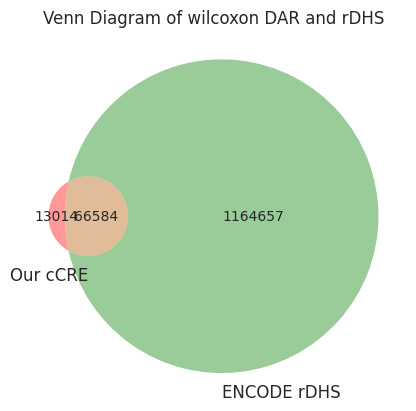

In [214]:
df_wil =pd.read_csv("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed", sep="\t", header=None)
inter_dar_wil ,non_overlapping_dar_wil = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed", bed_rdhs)
n_ovlp_wil = len(inter_dar_wil.to_dataframe().drop_duplicates(subset=["chrom","start","end"]))
n_dar_wil = len(df_wil)
non_ovlp_wil = len(non_overlapping_dar_wil)
venn2(subsets=( n_dar_wil-n_ovlp_wil, n_rDHS-n_ovlp_wil, n_ovlp_wil), set_labels=('Our cCRE', 'ENCODE rDHS'))
plt.title("Venn Diagram of wilcoxon DAR and rDHS")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_dar_wilcoxon_rDHS.svg", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

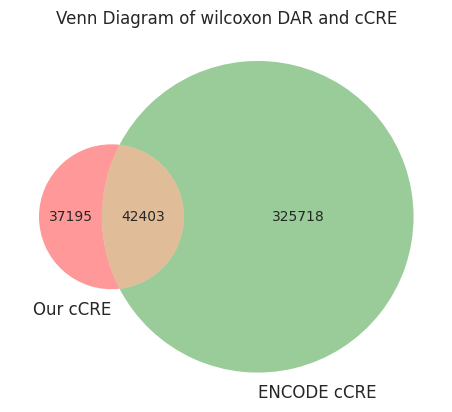

In [218]:
inter_dar_wil ,non_overlapping_dar_wil = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed", bed_encode)
n_ovlp_wil = len(inter_dar_wil.to_dataframe().drop_duplicates(subset=["chrom","start","end"]))
n_dar_wil = len(df_wil)
non_ovlp_wil = len(non_overlapping_dar_wil)
venn2(subsets=( n_dar_wil-n_ovlp_wil, n_encodeCCRE-n_ovlp_wil, n_ovlp_wil), set_labels=('Our cCRE', 'ENCODE cCRE'))
plt.title("Venn Diagram of wilcoxon DAR and cCRE")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_dar_wilcoxon_cCRE.svg", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [217]:
bed_encode

'/data2st1/junyi/output/atac0416/cCRE/mm10-cCREs.bed'

In [184]:
inte_dar_me.to_dataframe()

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb
0,chr1,183299141,183299642,chr1,183299148,183299498,EM10D2306186,EM10E0950019,"CTCF-only,CTCF-bound"
1,chr1,95451714,95452215,chr1,95451827,95452102,EM10D1080873,EM10E0446857,dELS
2,chr17,36231234,36231735,chr17,36231390,36231692,EM10D1560400,EM10E0641118,"DNase-H3K4me3,CTCF-bound"
3,chr2,29526281,29526782,chr2,29526357,29526677,EM10D2630698,EM10E1085336,dELS
4,chr11,98767223,98767724,chr11,98767448,98767618,EM10D1258079,EM10E0519066,"dELS,CTCF-bound"
...,...,...,...,...,...,...,...,...,...
109183,chr8,110465569,110466070,chr8,110465715,110465928,EM10D2927220,EM10E1208384,pELS
109184,chr2,29669624,29670125,chr2,29669764,29670094,EM10D1678500,EM10E0690161,dELS
109185,chr8,105304519,105305020,chr8,105304605,105304949,EM10D2924863,EM10E1207221,dELS
109186,chr17,66123319,66123820,chr17,66123180,66123342,EM10D1573524,EM10E0646470,dELS


In [181]:
inte_dar_me,non_overlapping_dar_mem = intersect_bed_files("/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed", bed_encode)
n_ovlp_me = len(inte_dar_me.to_dataframe().drop_duplicates(subset=["chrom","start","end"]))
n_dar = len(df_deg)
non_ovlp_me = len(non_overlapping_dar_mem)

In [186]:
venn2(subsets=( n_dar-n_ovlp_me, n_encodeCCRE-n_ovlp_me, n_ovlp_me), set_labels=('Our cCRE', 'ENCODE cCRE'))
plt.title("Venn Diagram of DAR and cCRE")
plt.savefig("/data2st1/junyi/output/atac0416/cCRE/venn_dar_cCRE.svg", dpi=300, bbox_inches='tight')
plt.close()

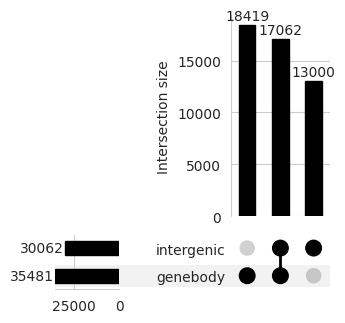

In [274]:
gene_regions = {
    'genebody': set(dict_annot_deg['genebody'].names),
    'intergenic': set(dict_annot_deg['intergenic'].names),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

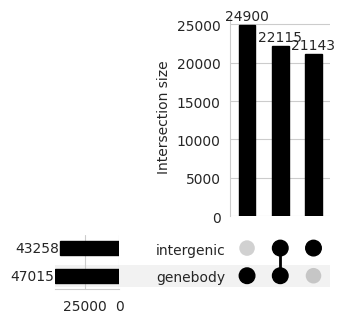

In [276]:
gene_regions = {
    'genebody': set(dict_annot_wil['genebody'].names),
    'intergenic': set(dict_annot_wil['intergenic'].names),
    # 'promoter': set(dict_annot['promoter2k'].names+"_"+dict_annot['promoter2k'].gene_name),
    # 'UTR': set(dict_annot['UTR'].names+"_"+dict_annot['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
    }
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

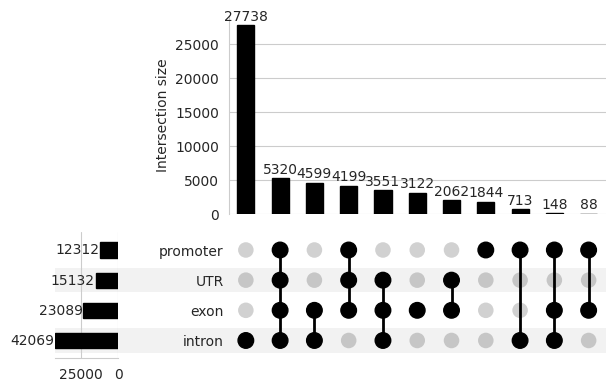

In [271]:
gene_regions = {
    'intron': set(dict_annot_wil['intron_selected'].names+"_"+dict_annot_wil['intron_selected'].gene_name),
    'exon': set(dict_annot_wil['exon_selected'].names+"_"+dict_annot_wil['exon_selected'].gene_name),
    'promoter': set(dict_annot_wil['promoter2k'].names+"_"+dict_annot_wil['promoter2k'].gene_name),
    'UTR': set(dict_annot_wil['UTR'].names+"_"+dict_annot_wil['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
}
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

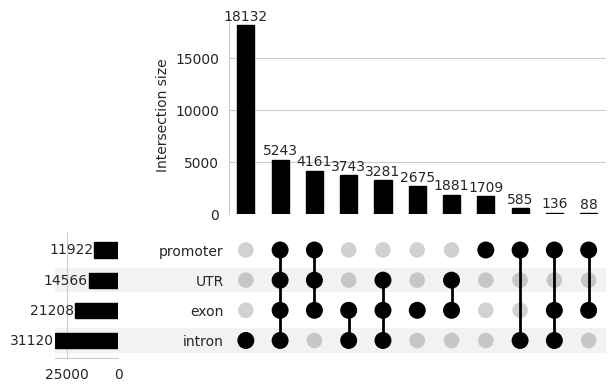

In [284]:
gene_regions = {
    'intron': set(dict_annot_deg['intron_selected'].names+"_"+dict_annot_deg['intron_selected'].gene_name),
    'exon': set(dict_annot_deg['exon_selected'].names+"_"+dict_annot_deg['exon_selected'].gene_name),
    'promoter': set(dict_annot_deg['promoter2k'].names+"_"+dict_annot_deg['promoter2k'].gene_name),
    'UTR': set(dict_annot_deg['UTR'].names+"_"+dict_annot_deg['UTR'].gene_name),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
}
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

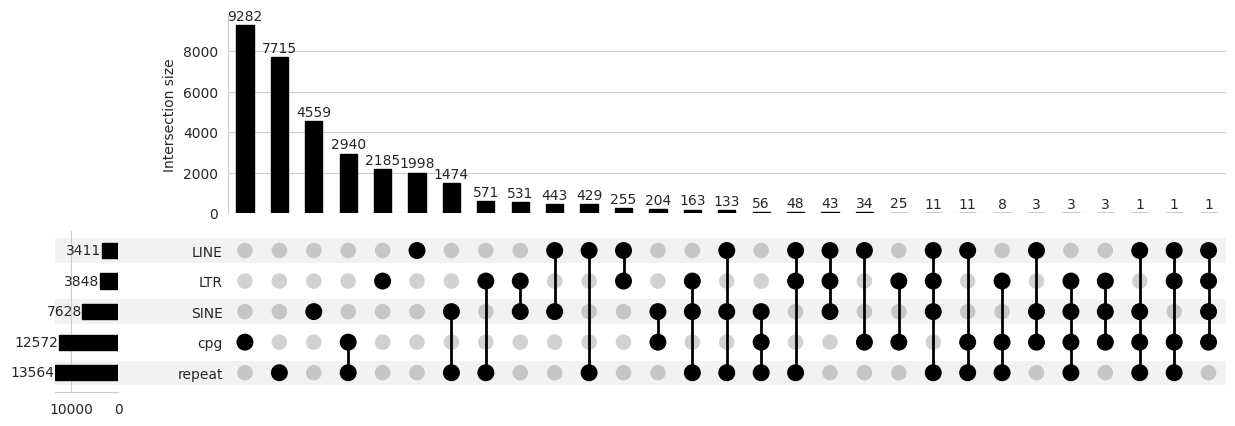

In [289]:
gene_regions = {
    'LINE': set(dict_annot_deg['LINE'].names+"_"+dict_annot_deg['LINE'].gene_name),
    'SINE': set(dict_annot_deg['SINE'].names+"_"+dict_annot_deg['SINE'].gene_name),
    'LTR': set(dict_annot_deg['LTR'].names+"_"+dict_annot_deg['LTR'].gene_name),
    'repeat': set(dict_annot_deg['Other_repeats'].names+"_"+dict_annot_deg['Other_repeats'].gene_name),
    'cpg': set(dict_annot_deg['cpg'].names+"_"+dict_annot_deg['cpg'].gene_name)
}
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()
    

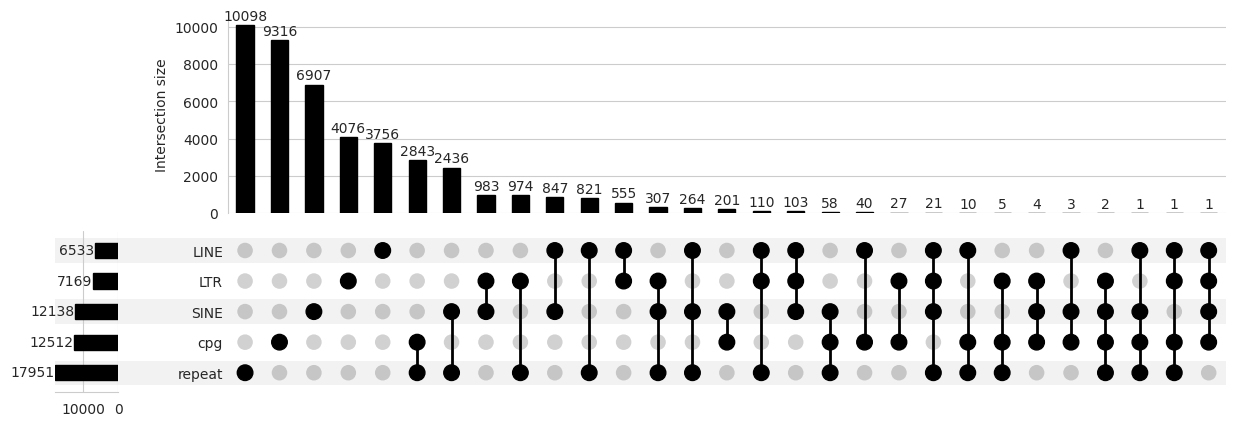

In [290]:
gene_regions = {
    'LINE': set(dict_annot_wil['LINE'].names+"_"+dict_annot_wil['LINE'].gene_name),
    'SINE': set(dict_annot_wil['SINE'].names+"_"+dict_annot_wil['SINE'].gene_name),
    'LTR': set(dict_annot_wil['LTR'].names+"_"+dict_annot_wil['LTR'].gene_name),
    'repeat': set(dict_annot_wil['Other_repeats'].names+"_"+dict_annot_wil['Other_repeats'].gene_name),
    'cpg': set(dict_annot_wil['cpg'].names+"_"+dict_annot_wil['cpg'].gene_name)
}
gene_regions = from_contents(gene_regions)
ax_dict = UpSet(gene_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()
    

In [285]:
df_dar_region_count = gene_regions.reset_index()
df_dar_region_count['count'] = df_dar_region_count.iloc[:,:-1].sum(axis=1)

In [286]:
df_dar_region_count.sort_values(by='count', ascending=False, inplace=True)

In [361]:
from scipy.stats import hypergeom
from scipy.stats import fisher_exact
def geom_dar(T,n,dict_annot,dict_annot_deg):
    # T = len(df_allpeaks)
    # n = len(df_)
    # n = len(df_)
    list_name = []
    list_p = []
    list_odd = []
    list_fold = []
    list_pctb = []
    list_pctdar = []
    for key in dict_annot.keys():
        M = len(dict_annot[key].drop_duplicates(subset=["chrom","start","end"]))
        m = len(dict_annot_deg[key].drop_duplicates(subset=["chrom","start","end"]))
        p_value = hypergeom.sf(m-1, T, M, n)  # 右尾检验
        Oddr = (m / (n - m)) / ((M - m) / (T - M - n + m))
        fold_enrichment = (m / n) / (M / T)
        pct_background = M / T
        pct_dar = m / n

        # print(T, M,n, m)

        # contingency_table = [[m, M - m], [n - m, T - M - n + m]]
        # Oddr, p_value_fisher = fisher_exact(contingency_table, alternative='greater')


        list_name.append(key)
        list_p.append(p_value)
        list_odd.append(Oddr)
        list_fold.append(fold_enrichment)
        list_pctb.append(pct_background)
        list_pctdar.append(pct_dar)

    df_geom = pd.DataFrame({
        'name': list_name,
        'p_value': list_p,
        'Oddr': list_odd,
        'fold_enrichment': list_fold,
        'pct_background': list_pctb,
        'pct_dar': list_pctdar
    })
    df_geom['significant'] = df_geom['p_value'].apply(lambda x: 'yes' if x < 0.05 else 'no')
    
    return df_geom
# T = len(df_allpeaks)
# n = len(df_deg)
# # n = len(df_)
# list_name = []
# list_p = []
# list_odd = []
# list_fold = []
# list_pctb = []
# list_pctdar = []
# for key in dict_annot.keys():
#     M = len(dict_annot[key].drop_duplicates(subset=["chrom","start","end"]))
#     m = len(dict_annot_deg[key].drop_duplicates(subset=["chrom","start","end"]))
#     p_value = hypergeom.sf(m-1, T, M, n)  # 右尾检验
#     Oddr = (m / (n - m)) / ((M - m) / (T - M - n + m))
#     fold_enrichment = (m / n) / (M / T)
#     pct_background = M / T
#     pct_dar = m / n

#     # print(T, M,n, m)

#     # contingency_table = [[m, M - m], [n - m, T - M - n + m]]
#     # Oddr, p_value_fisher = fisher_exact(contingency_table, alternative='greater')


#     print(f"{key}: {p_value}, {Oddr}, {fold_enrichment}")
#     list_name.append(key)
#     list_p.append(p_value)
#     list_odd.append(Oddr)
#     list_fold.append(fold_enrichment)
#     list_pctb.append(pct_background)
#     list_pctdar.append(pct_dar)


In [384]:
df_deg[["names","ctname","condition","region"]]

,names,ctname,condition,region
0,chr15:75086569-75087070,PFC_Glut,MC,PFC
1,chr12:120028551-120029052,PFC_Glut,MC,PFC
2,chrX:143482812-143483313,PFC_Glut,MC,PFC
3,chr2:98662045-98662546,PFC_Glut,MC,PFC
4,chr2:98662628-98663129,PFC_Glut,MC,PFC
...,...,...,...,...
92126,chr8:110465569-110466070,AMY_GABA,MW,AMY
92127,chr2:29669624-29670125,AMY_GABA,MW,AMY
92128,chr16:94919198-94919699,AMY_GABA,MW,AMY
92129,chr8:105304519-105305020,AMY_GABA,MW,AMY


In [ ]:
def gen_dict_with_query(dict_annot, qstring,df_deg):
    dict_merge = {}
    #subset_col = 'region'
    #qstring = 'condition.str.contains("MC")'
    for key in dict_annot.keys():
        df_merge = dict_annot_deg[key].merge(df_deg[["names","ctname","condition","region"]], on="names", how="left")
        result = df_merge.query(qstring)
        dict_merge[key] = result
    return dict_merge

In [398]:
df_deg.drop_duplicates(subset=["names"])

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation,distance,de_pval_adj
0,chr15:75086569-75087070,stim,0.432872,0.021699,1.011588e-88,-0.299096,0.125762,1.999109e-02,PFC_Glut,PFC,MC,Gm28502,ENSMUSG00000099452.1,75076209,75079094,-,genebody,-7476,9.510063e-86
1,chr12:120028551-120029052,stim,0.480524,0.024779,5.125947e-84,0.225606,0.120315,5.658753e-02,PFC_Glut,PFC,MC,Tmem196,ENSMUSG00000048004.15,119945821,120021246,+,genebody,-7306,3.234648e-81
2,chrX:143482812-143483313,stim,0.676692,0.040407,3.030414e-63,-0.410343,0.157938,1.027334e-02,PFC_Glut,PFC,MC,Pak3,ENSMUSG00000031284.16,143518590,143797796,+,genebody,35278,4.431668e-61
3,chr2:98662045-98662546,stim,0.504651,0.031239,5.452844e-59,-1.212180,0.093709,5.131220e-38,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,6.164123e-57
4,chr2:98662628-98663129,stim,0.525859,0.037705,1.715753e-44,-0.758739,0.097764,1.811849e-14,PFC_Glut,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,7.114042e-43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92123,chr11:60176417-60176918,stim,-0.088886,0.045841,4.912257e-02,-0.419944,0.150944,5.957374e-03,AMY_GABA,AMY,MW,Rai1,ENSMUSG00000062115.15,60105012,60199197,+,genebody,0,4.928932e-02
92124,chr2:158743696-158744197,stim,-0.142601,0.073285,4.912315e-02,0.005755,0.198035,9.877142e-01,AMY_GABA,AMY,MW,Ppp1r16b,ENSMUSG00000037754.13,158665397,158766334,+,genebody,0,4.928932e-02
92126,chr8:110465569-110466070,stim,-0.112227,0.058291,4.932913e-02,0.220969,0.189618,2.729488e-01,AMY_GABA,AMY,MW,Hydin,ENSMUSG00000059854.8,110266976,110610253,+,genebody,0,4.945411e-02
92127,chr2:29669624-29670125,stim,-0.142648,0.073045,4.936132e-02,0.079156,0.198688,6.719162e-01,AMY_GABA,AMY,MW,Rapgef1,ENSMUSG00000039844.20,29619719,29740978,+,genebody,0,4.947963e-02


In [409]:
df_wil

,0,1,2
0,chr2,98666917,98667418
1,chr2,98662045,98662546
2,chr2,98666414,98666915
3,chr9,35305176,35305677
4,chr2,98662628,98663129
...,...,...,...
79593,chr2,149768495,149768996
79594,chr12,41674762,41675263
79595,chr2,28068461,28068962
79596,chr5,71011211,71011712


In [410]:
T = len(df_allpeaks)
n = len(df_deg.drop_duplicates(subset=["names"]))
df_geom_mem = geom_dar(T,n,dict_annot,dict_annot_deg)
n2 = len(df_wil.drop_duplicates())
df_geom_wil = geom_dar(T,n2,dict_annot,dict_annot_wil)

<Axes: xlabel='fold_enrichment', ylabel='name'>

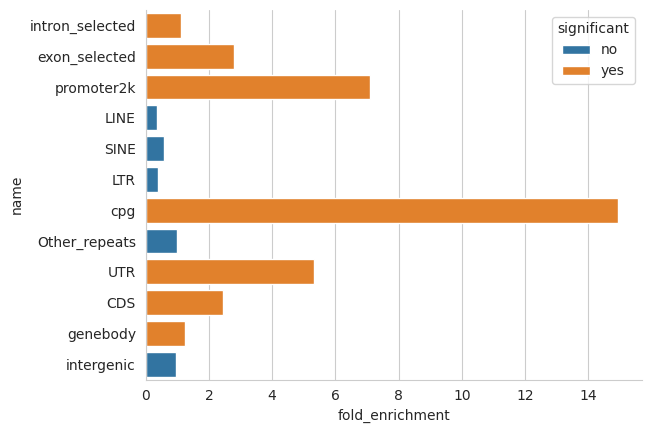

In [404]:
sns.barplot(data=df_geom_mem, y='name', x='fold_enrichment',hue='significant', orient='h',hue_order=['no','yes'])

<Axes: xlabel='fold_enrichment', ylabel='name'>

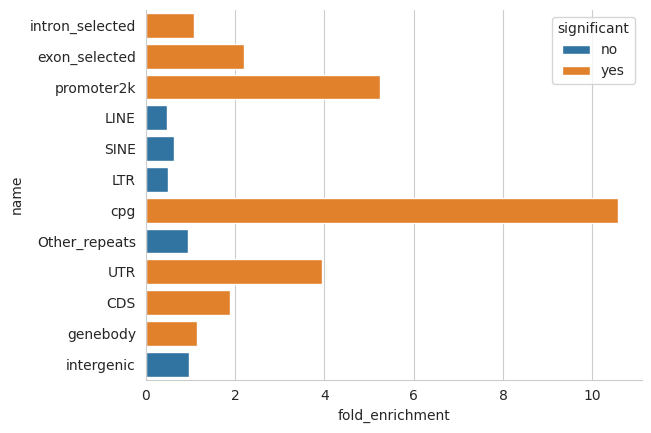

In [412]:
sns.barplot(data=df_geom_wil, y='name', x='fold_enrichment',hue='significant', orient='h',hue_order=['no','yes'])

In [457]:
df_deg.query(qstring).names.unique()

array(['chr2:98662045-98662546', 'chr15:75086569-75087070',
       'chr9:3001884-3002385', 'chr2:98666917-98667418',
       'chrX:143482812-143483313', 'chr1:183299141-183299642',
       'chr14:19418561-19419062', 'chr2:98662628-98663129',
       'chr18:40308019-40308520', 'chr13:3372900-3373401',
       'chr12:120028551-120029052', 'chr18:3005620-3006121',
       'chr9:35305176-35305677', 'chr2:98666414-98666915',
       'chr17:39845723-39846224', 'chr1:95451714-95452215',
       'chr17:39845182-39845683', 'chr11:46675671-46676172',
       'chr14:19417609-19418110', 'chrY:90740205-90740706',
       'chr9:3025299-3025800', 'chr6:103648949-103649450',
       'chr2:181918405-181918906', 'chr13:119596224-119596725',
       'chr13:119597832-119598333', 'chr10:22142394-22142895',
       'chr14:19417080-19417581', 'chr2:98664878-98665379',
       'chr17:36231234-36231735', 'chr9:3006552-3007053',
       'chr14:19415984-19416485', 'chr17:39848454-39848955',
       'chr13:119596729-119597230',

In [455]:
qstring = 'condition.str.contains("MC") and ctname.str.contains("PFC_GABA")'
dic_merge_mem = gen_dict_with_query(dict_annot, qstring,df_deg)
len_mc = len(df_deg.query(qstring).names.unique())
df_geom_memMC = geom_dar(T,len_mc,dict_annot,dic_merge_mem)
df_geom_memMC
#sns.barplot(data=df_geom_memMC, y='name', x='fold_enrichment',hue='significant', orient='h',hue_order=['no','yes'])

,name,p_value,Oddr,fold_enrichment,pct_background,pct_dar,significant
0,intron_selected,0.0,-0.925562,79.481934,0.534853,42.511182,yes
1,exon_selected,0.0,-7.271576,286.510845,0.132396,37.932907,yes
2,promoter2k,0.0,-38.857771,805.816869,0.031948,25.744409,yes
3,LINE,0.0,-6.036511,14.756750,0.200699,2.961661,yes
4,SINE,0.0,-2.999312,31.911555,0.275322,8.785942,yes
5,LTR,0.0,-5.311079,17.767971,0.206424,3.667732,yes
6,cpg,0.0,-98.727000,1759.308735,0.017317,30.466454,yes
7,Other_repeats,0.0,-2.929132,77.925683,0.268627,20.932907,yes
8,UTR,0.0,-22.122799,598.442585,0.051678,30.926518,yes
9,CDS,0.0,-14.385605,247.147951,0.072650,17.955272,yes


In [ ]:
bed_intron = "/data2st1/junyi/generegion_vM33/intron.bed"

intron, non_intron = intersect_bed_files(bed_allpeaks, bed_intron)

df_intron = intron.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])

num_intron = len(df_intron)

In [ ]:
df_intron.to_csv("/data2st1/junyi/output/cCRE/ALL_sampled_peaks_intron.bed", sep="\t", index=False)

In [ ]:
bed_intron = "/data2st1/junyi/generegion_vM33/exon.bed"
exon = BedTool(bed_intron)
exon, non_ie = intersect_bed_objects(non_intron, exon)


In [ ]:
df_exon = exon.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_exon = len(df_exon)

In [ ]:
promoter = BedTool("/data2st1/junyi/generegion_vM33/promoter.bed")
promoter, non_iep = intersect_bed_objects(non_ie, promoter)
df_promoter = promoter.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_promoter = len(df_promoter)

In [ ]:
SINES = BedTool("/data2st1/junyi/generegion_vM33/sines.bed")
SINES, non_sines = intersect_bed_files(non_iep, SINES)
df_sines = SINES.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_sines = len(df_sines)

In [ ]:
LTRS = BedTool("/data2st1/junyi/generegion_vM33/ltrs.bed")
LTRS, non_LTRS = intersect_bed_files(non_iep, LTRS)
df_ltrs = LTRS.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_ltrs = len(df_ltrs)

In [ ]:
LINES = BedTool("/data2st1/junyi/generegion_vM33/lines.bed")
LINES, non_LINES = intersect_bed_files(non_iep, LINES)
df_lines = LINES.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_lines = len(df_lines)


In [ ]:
intergenic = '/data2st1/junyi/generegion_vM33/intergenic.bed'
intergenic, non_intergenic = intersect_bed_files(bed_allpeaks, intergenic)
df_intergenic = intergenic.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_intergenic = len(df_intergenic)

In [ ]:
other_repeat = '/data2st1/junyi/generegion_vM33/other_repeats.bed'
other_repeat, non_other_repeat = intersect_bed_files(non_iep, other_repeat)
df_other_repeat = other_repeat.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_other_repeat = len(df_other_repeat)

In [ ]:
cpgi = '/data2st1/junyi/generegion_vM33/cpg.bed'
cpgi, non_cpgi = intersect_bed_files(bed_allpeaks, cpgi)
df_cpgi = cpgi.to_dataframe().drop_duplicates(subset=['chrom', 'start', 'end'])
num_cpgi = len(df_cpgi)

In [ ]:
num_cpgi

In [ ]:
import seaborn as sns

data = {'Region': ['Intron', 'Exon', 'Promoter', 'SINES', 'LTRs', 'LINES', 'Intergenic', 'Other Repeats', 'CpG Islands'],
        'Number of Peaks': [num_intron, num_exon, num_promoter, num_sines, num_ltrs, num_lines, num_intergenic, num_other_repeat, num_cpgi]}
df = pd.DataFrame(data)


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(df['Number of Peaks'], labels=df['Region'], autopct='%1.1f%%',pctdistance=1.15,labeldistance=1.28)
plt.show()


In [ ]:
# import subprocess
# filename= '/data2st1/junyi/output/cCRE/ALL_sampled_peaks.bed'
# command_str = f"/home/junyichen/liftOver {filename} /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/cCRE/ALL_sampled_peaks_mm10.bed /data2st1/junyi/output/cCRE/peaks_unmap.bed"
# print(command_str)
# subprocess.run(command_str, shell=True)

In [ ]:
# bed_allpeaks = "/data2st1/junyi/output/cCRE/ALL_sampled_peaks_mm10.bed"
# bed_encode = "/data2st1/junyi/output/convert_enhancer.bed"

# merged, non_overlapping = intersect_bed_files(bed_allpeaks, bed_encode)

In [ ]:
# merged.saveas("/data2st1/junyi/output/cCRE/merged_mm10.bed")
# non_overlapping.saveas("/data2st1/junyi/output/cCRE/non_overlapping_mm10.bed")

In [192]:

# 打开 bigWig 文件
bw_pcon = "/data2st1/junyi/phascon/mm10.60way.phastCons.bw"

In [196]:
def cal_pasconscore(input_bed, input_bw):

    bw = pyBigWig.open(input_bw)
    
    scores_list_non = []

    with open(input_bed, "r") as bed_file:
        for line in bed_file:
            line_s = line.strip().split('\t')
            chrom, start, end= line_s[0], line_s[1], line_s[2]
            start = int(start)
            end = int(end)
            summit = (start +
                    end) // 2
            

            # 获取 PhastCons 分数
            try:
                scores = bw.values(chrom, summit -250, summit + 250)
                scores = [score for score in scores if score is not None]
            except:
                continue    
            # 计算平均分数
            # mean_score = np.mean(scores)
            # print(f"Region {name} ({chrom}:{start}-{end}): Mean PhastCons score = {mean_score}")
            scores_list_non.append(scores)

    scores_array_non = np.array(scores_list_non)
    scores_array_non = np.nan_to_num(scores_array_non)
    #mean_value_non = np.mean(scores_array_non, axis=0)

    return scores_array_non

In [207]:
df_dar_wil = pd.read_csv("/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv")

In [211]:
df_dar_wil.names.str.split(r"[:-]",expand=True).to_csv("/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed",index=False,header=False, sep="\t")

In [197]:
ovlp_rdhs = "/data2st1/junyi/output/atac0416/cCRE/overlap_rdhs.bed"
scores_array = cal_pasconscore(ovlp_rdhs, bw_pcon)
mean_value = np.mean(scores_array, axis=0)

In [198]:
# 
non_ovlp_rdhs = "/data2st1/junyi/output/atac0416/cCRE/non_overlapp_rdhs.bed"
scores_array_non = cal_pasconscore(non_ovlp_rdhs, bw_pcon)
mean_value_non = np.mean(scores_array_non, axis=0)

In [199]:
dar_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed"
scores_array_dar = cal_pasconscore(dar_bed, bw_pcon)
mean_value_dar = np.mean(scores_array_dar, axis=0)

In [ ]:
dar_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_memento.bed"
scores_array_dar = cal_pasconscore(dar_bed, bw_pcon)
mean_value_dar = np.mean(scores_array_dar, axis=0)

In [212]:
wil_bed = "/data2st1/junyi/output/atac0416/cCRE/dar_wilcoxon.bed"
scores_array_wil = cal_pasconscore(wil_bed, bw_pcon)
mean_value_wil = np.mean(scores_array_wil, axis=0)

In [200]:
sns.set_style("whitegrid")


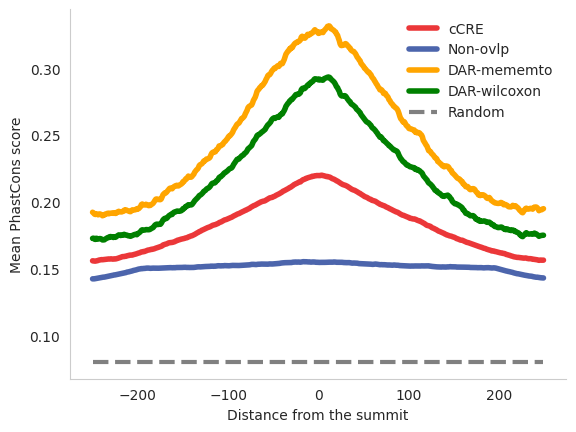

In [213]:
x = np.arange(-250, 250)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

plt.plot(x, mean_value,color='#EB3739', label='cCRE',linewidth=4)
plt.plot(x, mean_value_non, color='#4C65AC', label='Non-ovlp',linewidth=4)
plt.plot(x, mean_value_dar, color='Orange', label='DAR-mememto',linewidth=4)
plt.plot(x, mean_value_wil, color='green', label='DAR-wilcoxon',linewidth=4)
plt.plot(x, np.zeros_like(x)+0.08, color='grey',label='Random', linestyle='--', linewidth=3)
plt.xlabel('Distance from the summit')
plt.ylabel('Mean PhastCons score')
plt.legend(loc='upper right',frameon=False)
plt.grid(visible=False)
plt.axis('tight')
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)

plt.show()

